<a href="https://colab.research.google.com/github/Next-Sunshine/TTF0318/blob/master/federated_learning_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@test {"skip:true"}
!pip install --quiet --upgrade tensorflow_federated

     |████████████████████████████████| 430kB 2.8MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 20.0MB 5.0MB/s 
     |████████████████████████████████| 2.8MB 49.2MB/s 
     |████████████████████████████████| 296kB 37.2MB/s 
     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 2.2MB 50.9MB/s 
     |████████████████████████████████| 450kB 52.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello,world!')()

b'Hello,world!'

In [0]:
#装载数据集，EMNIST数据集
#load_data()返回的数据集是tff.simulation.ClientData的实例
#tff.simulation.clientData.create_tf_dataset_for_client返回的tf.data.dataset将在每次迭代中生成collections.OrderedDict对象，并具有以下键和值：
#‘pixels':dtype=tf.float32且shape为[28，28]的tf.Tensor，包含手写数字的像素，其值在[0.0，1.0]范围内
#‘label'：dtype=tf.int32且形状为[1]的tf.Tensor，是相应像素的类标签
#标签[0-9]对应于数字类，标签[10-35]对应于大写类（例如，标签11是“B”），标签[36-61]对应于小写类（例如，标签37是“b”）。
#pixels是图片的key，label是对应图片标签的key
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 1s 0us/step


In [0]:
#存放着用户id的数组？
len(emnist_train.client_ids) #输出3383
len(emnist_test.client_ids) #输出3383

3383

In [0]:
#element_type_structure查看类型结构？
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [0]:
#create_tf_dataset_for_client接收用户client_id作为参数，返回创造的数据集
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0]
)
#在一个博客上看到了另外一种写法：example_element = iter(example_dataset).next()
#iter(example_dataset)获取数据集的迭代器，那么next（iter（example_dataset））就是该数据集的第一个元素
example_element = next(iter(example_dataset))
example_element['label'].numpy()

5

In [0]:
#这个打印出来是一群数[0,1]，还有换行符
str(example_element['pixels'].numpy())

'[[1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.        ]\n [1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.        ]\n [1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.        ]\n [1.         1.         1.         1.         1.         1.\n  1.         1.         1.         1.         1.         1.\n 

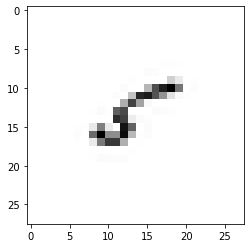

In [0]:
from matplotlib import pyplot as plt
#imshow(X,cmap)X可以是数列类格式、或者PIL图片,cmap是colormap，aspect有None，equal，auto（该表图片横纵比以适应坐标轴），scalar
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
#这里这个画应该是一种很随意的，因为不想再用所以命名就是_
#plt.imshow（）负责对图像进行处理并调整其格式但是不能显示，必须在其后跟着plt.show()才能成功显示出来
_=plt.show()

In [0]:

NUM_CLIENTS = 10  #用户数量
#一个epoch指代所有的数据送入网络中完成一次前向计算及反向传播的过程
#epoch可理解为轮数嘛？数据多样化越强epoch应该越大，一个epoch就是把整个训练集过一遍
#iterations就是完成一次epoch所需的batch个数
NUM_EPOCHS = 5  #轮数
BATCH_SIZE = 20  #批大小
#shuffle_buffer会影响转换的随机性？
SHUFFLE_BUFFER = 100  #洗牌缓冲区是什么？？？
#添加预取缓冲区可以通过将数据的预处理与下游计算重叠来提高性能。
PREFETCH_BUFFER = 10   #预取缓冲区

#由于数据已经是tf.data.Dataset因此可以使用数据集转换来完成预处理。
#在这里我们将28×28图像展平成784个元素数组，对单个示例进行无序排列，将它们组织成批
#将特征从pixels和label重命名为x和y以便于Keras一起使用，还对数据集进行一次重复，以运行多个时间段
def preprocess(dataset):
  #batch_format_fn将像素和标签转换成x和y
  def batch_format_fn(element):
    #Flatten a batch 'pixels' and return the features as an 'OrderedDict'
    return collections.OrderedDict(
        #-1理解为一个正整数通配符，它代替任何整数，所以reshape只指定了x的列数，将pixels弄成784列
        x = tf.reshape(element['pixels'], [-1,784]),
        #将label处理成一列，多少行无关
        y = tf.reshape(element['label'], [-1,1])
    )
  #dataset.repeat(epoch_size)就是epoch，进行多遍训练
  #dataset.shuffle(shuffle_size)就是将数据打乱，数值越大，混乱程度越大
  #dataset.batch(batch_size)按照顺序取数据，每次取batch_size大小的数据
  #dataset.map应该就是将map里面的fn应用到dataset里面的每一个元素吧
  #dataset.prefetch（m）转换预取其直接输入的m个元素。在这种情况下，由于dataset.batch(n).prefetch(m)的直接输入是dataset.batch（n），并且该数据集的每个元素都是一个批（n个元素），所以它将预取m个批。
  #prefetch可以保证下一个batch的数据对于 GPU 可以立即可用，减少 GPU 的数据等待时间.
  #其中，m是预先被拉取数据的batches数.一般情况下，m=1.如果处理每个batch的耗时不同时，可以增加其值.
  #官方说dataset.repeat放在shuffle之前可以提高性能
  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [0]:
#对示例数据集进行预处理
preprocessed_example_dataset = preprocess(example_dataset)
#预处理之后x代表图片array，y代表每一行的标签
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[8],
                     [8],
                     [5],
                     [3],
                     [3],
                     [4],
                     [6],
                     [7],
                     [3],
                     [9],
                     [3],
                     [2],
                     [8],
                     [7],
                     [1],
                     [3],
                     [2],
                     [4],
                     [3],
                     [3]], dtype=int32))])

In [0]:
#这里的client_data应该说的是mnist_train这一类的，通过load()加载来的
#make_federated_data(client_data,client_ids)是在为每一个用户id创建联邦数据
#从给定的用户集构造一个数据集列表，作为一轮培训或评估的输入。
def make_federated_data(client_data, client_ids):
  return [
    #tff.simulation.clientData.create_tf_dataset_for_client返回的tf.data.dataset将在每次迭代中生成collections.OrderedDict对象，并具有以下键和值：
    #‘pixels':dtype=tf.float32且shape为[28，28]的tf.Tensor，包含手写数字的像素，其值在[0.0，1.0]范围内
    #‘label'：dtype=tf.int32且形状为[1]的tf.Tensor，是相应像素的类标签
    #create_tf_dataset_for_client接收用户client_id作为参数，返回创造的数据集
    preprocess(client_data.create_tf_dataset_for_client(x))
    for x in client_ids
  ]

In [0]:
#sample_clients是在获得给定用户数量的用户id
#！！！改动在这里，应该模拟随机采样，用户是随机的
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)


print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [0]:
#Keras模型
def create_keras_model():
  #另外，model.Sequential其他用法：建立一个最终输出维度为10的分类结果的全连接神经网络。使用.add()函数进行各个层的堆叠
  #model = keras.Sequential() model.add(keras.layers.Dense(64, activation='relu')) model.add(keras.layers.Dense(64, activation='relu'))
  #model.add(keras.layers.Dense(10, activation='softmax'))
  #或者通过将层的列表传递给Sequential的构造函数，来创建一个Sequential模型，返回一个tf.keras.model对象
  return tf.keras.models.Sequential([
    #shape=(784,)代表一个有784个元素的一维数组，例如[2,2]的形状是(2,)而[[2],[2]]的形状是(2,1)
    tf.keras.layers.Input(shape = (784,)),
    tf.keras.layers.Dense(10, kernel_initializer='zeros'),
    tf.keras.layers.Softmax(),
  ])

In [0]:
#为了将任何模型与TFF一起使用，需要将其包装在TFF.learning.model接口的实例中，该接口公开了用于标记模型的前向传递、元数据属性等的方法
#类似于Keras，但还引入了其他元素，例如控制计算联合度量的过程的方法。scop:范围
def model_fn():
  # We _must_create a new model here, and not capture it from an external
  #scop. TFF will call this within different graph contexts.
  #from_keras_model(keras_model,loss,input_spec=None,loss_weights=None,metrics=None,dummy_batch=None)
  #-keras_model:未编译的tf.keras.Model对象
  #-loss:具有两个成批张量参数y_true和y_pred的可调用对象，并返回损失。如果模型具有多个输出，则可以通过传递字典或损失列表来在每个输出上使用不同的损失。然后，将由模型最小化的损失值将是所有单个损失的总和，每个损失都由loss_weights加权。
  #-input_spec:（可选）可转换为tff.Type的值，指定模型期望的参数类型。请注意，这必须是两个元素的复合结构，同时将输入模型以生成预测的数据指定为第一个元素，并将预期的地面事实类型作为第二个元素。当我们删除dummy_batch时，将需要此参数；当前，必须精确指定这两个之一。
  #-loss_weight:（可选）指定标量系数（Python浮点数）以加权不同模型输出的损耗贡献的列表或字典。 然后，将由模型最小化的损失值将是所有单个损失的加权总和，并由loss_weights系数加权。 如果是列表，则期望与模型的输出具有1：1映射。 如果是张量，则期望将输出名称（字符串）映射到标量系数。
  #-metrics:（可选）tf.keras.metrics.Metric对象的列表。
  #-dummy_batch:dummy_batch ：（可选，不建议使用）嵌套的值结构，可以将其转换为成批张量，其形状和类型与输入keras_model的形状和类型相同。张量的值并不重要，可以用任何合理的输入值填充。
  keras_model = create_keras_model()
  #返回一个给定的tff模型
  return tff.learning.from_keras_model(
      keras_model,
      #批样本？
      dummy_batch=sample_batch,
      #tf.keras.losses.SparseCategoricalCrossentropy()计算标签和预测之间的交叉熵损失。标签是以整数的形式提供而不是独热码
      #独热码是CategoricalCrossentropy
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      #该评估器能够对模型预测的结果与真实结果进行比较，并输出预测正确的样本数占总样本数的比例。
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

In [0]:
#有了一个包装为tf.learning.model的模型，可以调用tff.learning.build_federated_averaging_process构造联邦平均算法
iterative_process = tff.learning.build_federated_averaging_process(
    #model_fn是构造函数，而不是构建好的实例
    model_fn,
    #客户端的优化器，这里以后可以照抄
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    #服务器的优化器函数
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
str(iterative_process.initialize.type_signature)
#服务器状态由一个模型（将分发给所有设备的MNIST的初始模型参数）和优化器状态（服务器维护的附加信息，例如用于超参数计划的轮次数等）组成

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [0]:
#调用初始化计算来构造服务器状态
state = iterative_process.initialize()

In [0]:
#next的签名：SERVER_STATE,FEDERATED_DATA->SERVER_STATE,TRAINING_METRICS
state, metrics = iterative_process.next(state, federated_train_data)
print('round 1, metrics={}'.format(metrics))

round 1, metrics=<sparse_categorical_accuracy=0.11954732239246368,loss=3.1037683486938477,keras_training_time_client_sum_sec=0.0>


In [0]:
#每轮联合训练后，训练损失都在减少，说明模型正在收敛。
NUM_ROUNDS = 11
for round_num in range(2,NUM_ROUNDS):
  state,metrics = iterative_process.next(state, federated_train_data)
  print('round{:2d}, metrics={}'.format(round_num, metrics))

round 2, metrics=<sparse_categorical_accuracy=0.14094650745391846,loss=2.9814815521240234,keras_training_time_client_sum_sec=0.0>
round 3, metrics=<sparse_categorical_accuracy=0.14835390448570251,loss=2.850893497467041,keras_training_time_client_sum_sec=0.0>
round 4, metrics=<sparse_categorical_accuracy=0.18086419999599457,loss=2.640409469604492,keras_training_time_client_sum_sec=0.0>
round 5, metrics=<sparse_categorical_accuracy=0.20061728358268738,loss=2.4948813915252686,keras_training_time_client_sum_sec=0.0>
round 6, metrics=<sparse_categorical_accuracy=0.2146090567111969,loss=2.4961931705474854,keras_training_time_client_sum_sec=0.0>
round 7, metrics=<sparse_categorical_accuracy=0.25390946865081787,loss=2.262115240097046,keras_training_time_client_sum_sec=0.0>
round 8, metrics=<sparse_categorical_accuracy=0.24320988357067108,loss=2.3826146125793457,keras_training_time_client_sum_sec=0.0>
round 9, metrics=<sparse_categorical_accuracy=0.3047325015068054,loss=2.0886857509613037,keras

In [0]:
#使用Tensorboard可视化这些联邦计算的度量
#创建目录和相应的摘要编写器
#@test {"skip": true}
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

In [0]:
#!!!太坑了，我以为@test是无关紧要的东西，emmm，就省略了，没想到就凉凉
#@test {"skip": true}
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    for name, value in metrics._asdict().items():
      tf.summary.scalar(name, value, step=round_num)

In [0]:
#!kill 641

In [0]:
#@test {"skip":true}
%load_ext tensorboard
%tensorboard --logdir /tmp/logs/scalars/ --port=0

In [0]:
#@test {"skip":true}
#Run this cell to clean your directory of old output for future graphs from this drrectory.
!rm -R /tmp/logs/scalars/*

In [0]:
#namedtuple（）返回具有命名字段的元组的新子类，将weights等作为MnistVariables的属性包装在MnistVariables中
#定义一个数据结构来表示整个集合。这将包括变量，如我们将要训练的权重和偏差，以及变量，
#这些变量将保存我们在训练期间更新的各种累积统计和计数器，loss_sum, accuracy_sum, 和 num_examples.。
#定义了一个变量集合来表示所有变量
MnistVariables = collections.namedtuple(
    'MnistVariables','weights bias num_examples loss_sum accuracy_sum'
)

In [0]:
#创建变量的方法
#将所有统计数据表示为tf.float32，因为这将在稍后阶段消除类型转换的需要。将变量初始值设定项包装为lambdas是资源变量强加的要求。
def create_mnist_variables():
  return MnistVariables(
      #tf.Variables()定义一个变量，一般会把权重这些这样定义
      #tf.placeholder()或者tf.TensorSpec()则定义一个固定类型的张量，一般输入输出会这样定义
      weights=tf.Variable(
          #定义形状以及初始化，权重将784维的向量变成10维的
          lambda: tf.zeros(dtype=tf.float32, shape=(784,10)),
          name='weights',
          trainable=True),
      bias=tf.Variable(
          #偏移的形状是有10个元素的1维向量
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      #样本数：不可训练，同理损失和以及精度和也是，这些数都将初始化为0
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False)
  )

In [0]:
def mnist_forward_pass(variables, batch):
  #softmax()输出样本属于各个类别的概率
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  #tf.argmax(y,1)将y中的最大值！！下标！！取出来
  #tf.cast()则将tf.argmax(y,1)得到的类型转换成tf.int32类型的
  predictions = tf.cast(tf.argmax(y,1), tf.int32)

  #将batch['y']也就是label转变成1维数组
  flat_labels = tf.reshape(batch['y'], [-1])
  #计算交叉熵损失
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  #计算准确率，即将预测值和label进行对比，得到True和False的数组，然后将bool类型转换成32位浮点，然后再求平均值，也就是在计算精度
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  #样本数=label的数量然后转变成32位浮点？
  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  #更新样本数，变量里面的样本数+=本批样本数
  variables.num_examples.assign_add(num_examples)
  #更新损失和，损失和+=损失×本批样本数   自动带上了本地的样本权重？这是什么意思，仔细看了一下后面的损失，还真的大于了1
  variables.loss_sum.assign_add(loss * num_examples)
  #更新精度和，精度和+=精度×本批样本数
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

In [0]:
#计算本地用户度量，metrics 度量
#input_metrics参数对应于上面get_local_mnist_metrics返回的OrderedDict
def get_local_mnist_metrics(variables):
  return collections.OrderedDict(
      num_examples=variables.num_examples,
      loss=variables.loss_sum / variables.num_examples,
      accuracy=variables.accuracy_sum / variables.num_examples
  )

In [0]:
#聚合每个设备发出的本地度量
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return collections.OrderedDict(
    num_examples=tff.federated_sum(metrics.num_examples),
    #使用loss和/num_examples来计算平均损失
    loss=tff.federated_mean(metrics.loss, metrics.num_examples),
    accuracy=tff.federated_mean(metrics.accuracy, metrics.num_examples)
  )

In [0]:
#构建tff.learning.model实例
class MnistModel(tff.learning.Model):
  
  def __init__(self):
    self._variables = create_mnist_variables()

  #property代表属性，可训练变量即权重和偏移（权重和偏移是model的属性）
  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  #本地变量，权重和偏移是model的变量存在SERVER所以本地变量应该就是剩下那几个
  @property
  def local_variables(self):
    return [
      self._variables.num_examples, self._variables.loss_sum,
      self._variables.accuracy_sum
    ]

  #模型应该描述它接受什么形式的数据（input_spec）
  @property
  def input_spec(self):
    return collections.OrderedDict(
      #TensorSpec和占位符一样，一般用来表示输入输出这种
      x=tf.TensorSpec([None, 784], tf.float32),
      y=tf.TensorSpec([None, 1], tf.int32))
  
  #@tf.function将python代码转换成图保存
  @tf.function
  def forward_pass(self, batch, training=True):
    #del删除training变量？
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_examples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_examples)
  
  #报告本地输出
  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  #联邦输出计算，报告聚合了本地计算的联邦结果
  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients


In [0]:
#对于联合平均，我们需要指定模型应该如何在每个批上进行本地训练。我们将在构建联邦平均算法时指定一个本地优化器。
#用新模型模拟联合训练
iterative_process = tff.learning.build_federated_averaging_process(
  MnistModel,
  client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02)
)

In [0]:
state = iterative_process.initialize()

In [0]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round 1, metrics={}'.format(metrics))

round 1, metrics=<num_examples=4860.0,loss=3.078794240951538,accuracy=0.1286008208990097>


In [0]:
for round_num in range(2,11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

ERROR! Session/line number was not unique in database. History logging moved to new session 62
round  2, metrics=<num_examples=4860.0,loss=2.912949323654175,accuracy=0.1384773701429367>
round  3, metrics=<num_examples=4860.0,loss=2.9531896114349365,accuracy=0.14897119998931885>
round  4, metrics=<num_examples=4860.0,loss=2.7291486263275146,accuracy=0.1639917641878128>
round  5, metrics=<num_examples=4860.0,loss=2.5692806243896484,accuracy=0.20843622088432312>
round  6, metrics=<num_examples=4860.0,loss=2.474888324737549,accuracy=0.21975308656692505>
round  7, metrics=<num_examples=4860.0,loss=2.3740530014038086,accuracy=0.2397119402885437>
round  8, metrics=<num_examples=4860.0,loss=2.20986008644104,accuracy=0.26851850748062134>
round  9, metrics=<num_examples=4860.0,loss=2.18491530418396,accuracy=0.2930041253566742>
round 10, metrics=<num_examples=4860.0,loss=2.041264295578003,accuracy=0.32325103878974915>


In [0]:
#使用tensorboard可视化
#使用Tensorboard可视化这些联邦计算的度量
#创建目录和相应的摘要编写器
#@test {"skip": true}
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

#!!!太坑了，我以为@test是无关紧要的东西，emmm，就省略了，没想到就凉凉
#@test {"skip": true}
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    for name, value in metrics._asdict().items():
      tf.summary.scalar(name, value, step=round_num)

#@test {"skip":true}
%load_ext tensorboard
%tensorboard --logdir /tmp/logs/scalars/ --port=0

In [0]:
#@test {"skip":true}
#Run this cell to clean your directory of old output for future graphs from this drrectory.
!rm -R /tmp/logs/scalars/*

In [0]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

In [0]:
str(evaluation.type_signature)

'(<<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,{<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <num_examples=float32@SERVER,loss=float32@SERVER,accuracy=float32@SERVER>)'

In [0]:
train_metrics = evaluation(state.model, federated_train_data)

In [0]:
str(train_metrics)

'<num_examples=4860.0,loss=1.523190975189209,accuracy=0.6388888955116272>'

In [0]:
federated_test_data = make_federated_data(emnist_test, sample_clients)
len(federated_test_data), federated_test_data[0]

(10,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [0]:
test_metrics = evaluation(state.model, federated_test_data)

In [0]:
str(test_metrics)

'<num_examples=580.0,loss=1.6153969764709473,accuracy=0.6034482717514038>'